In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import bambi as bmb 
# import hssm
import os
import arviz as az 
import pymc as pm
# hssm.set_floatX("float32")
random_seed = 10
from utils import *
sns.set_palette('colorblind')

## Read data

In [21]:
files = os.listdir('data/')
comb_data = pd.concat([extract_data(fname) for fname in files]).reset_index(drop=True)
comb_data = comb_data.loc[comb_data['rt'] < 10].reset_index(drop = True)
comb_data = comb_data.loc[comb_data['rt'] > 0.1].reset_index(drop = True)

comb_data['shape'] = 'noisy'
comb_data.loc[comb_data['bumps'] == 'single', 'shape'] = 'single_extremum'
comb_data.loc[comb_data['bumps'] == 'center', 'shape'] = 'three_extrema'
comb_data['participant_id'] = comb_data['participant']


# Basic Plotting

In [3]:
comb_data_participant = comb_data.groupby(['means', 'direction', 'shape', 'diff_dir', 'cond']).mean().reset_index()
comb_data_participant

C:\Users\tejas\AppData\Local\Temp\ipykernel_19616\521435429.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  comb_data_participant = comb_data.groupby(['means', 'direction', 'shape', 'diff_dir', 'cond']).mean().reset_index()


,means,direction,shape,diff_dir,cond,participant,trials.thisN,difference,rt,accuracy,response,participant_id
0,36.0,-1.0,single_extremum,-1.0,chart,164513.800000,137.000000,-9.200000,1.287945,0.933333,0.866667,164513.800000
1,36.0,-1.0,single_extremum,-1.0,numerical,119383.769231,143.615385,-10.000000,2.073434,0.461538,-0.076923,119383.769231
2,36.0,-1.0,single_extremum,-1.0,slider,116417.363636,183.818182,-9.181818,2.113928,0.545455,0.090909,116417.363636
3,36.0,-1.0,single_extremum,1.0,chart,154264.875000,169.000000,10.375000,1.339754,0.812500,0.625000,154264.875000
4,36.0,-1.0,single_extremum,1.0,numerical,119383.769231,131.076923,9.692308,0.878510,0.846154,0.692308,119383.769231
...,...,...,...,...,...,...,...,...,...,...,...,...
865,64.0,1.0,three_extrema,-1.0,numerical,119383.769231,168.000000,-9.461538,1.488471,0.846154,0.692308,119383.769231
866,64.0,1.0,three_extrema,-1.0,slider,116417.363636,139.454545,-10.000000,1.183802,0.818182,0.636364,116417.363636
867,64.0,1.0,three_extrema,1.0,chart,154264.875000,169.937500,9.000000,1.885519,0.812500,0.625000,154264.875000
868,64.0,1.0,three_extrema,1.0,numerical,129289.250000,138.416667,7.750000,1.151771,0.500000,0.000000,129289.250000


In [7]:
comb_data_participant.loc[comb_data_participant['cond'] == 'slider'].participant.unique().shape

(9,)

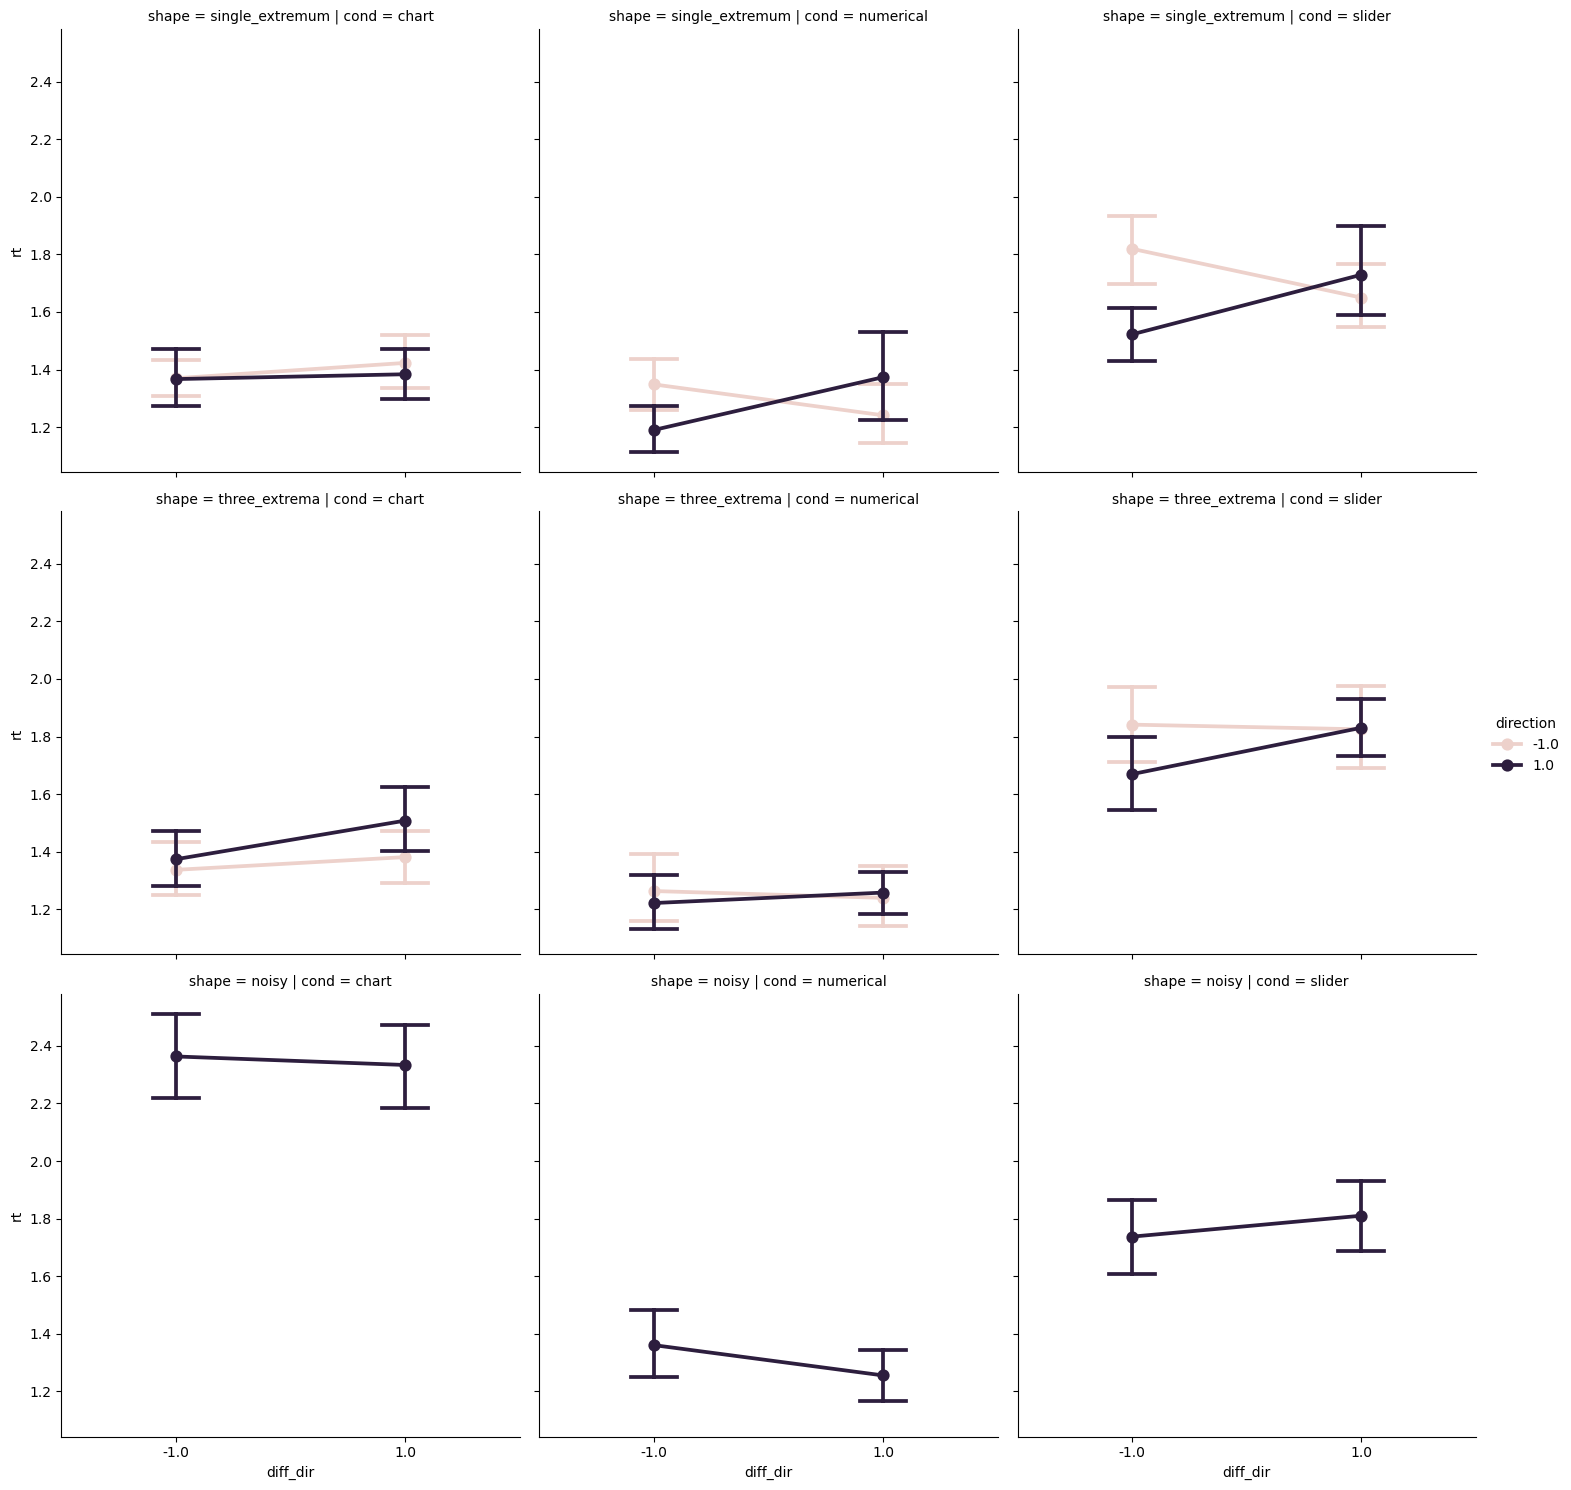

In [8]:
sns.catplot(x = 'diff_dir', y = 'rt', hue = 'direction', col = 'cond', row = 'shape', 
#             estimator='median',
            data = comb_data_participant, kind = 'point', capsize = 0.2)


## Non Hierarchical Linear Modeling

### Single Parameter Models

In [9]:
single_param_models = ['diff_dir', 'means', 'direction', 'shape', 'difference', 'cond']

In [10]:
def single_param_model_fits(single_param_models, dv = 'accuracy', family = 'bernoulli', data = comb_data):
    model_single_param_samples = {}
    for param in single_param_models:
        print('Fittting param: ', param)
        models_oneparam_nh = bmb.Model(f'{dv}~{param}', data = comb_data, family= family)
        models_oneparam_nh.build()
        model_single_param_samples[param] = models_oneparam_nh.fit(idata_kwargs={"log_likelihood": True})
        
    return model_single_param_samples

### All parameter models

#### Additive model

In [18]:
def additive_model_fit(dv = 'accuracy', family = 'bernoulli', data = comb_data):
    allparam_nh = bmb.Model(f'{dv}~ C(diff_dir) +  C(direction) + shape + difference + cond + means', 
    data = comb_data, family=family)
    allparam_nh.build()
    # allparam_nh.graph()
    allparam_nh_samples = allparam_nh.fit(idata_kwargs={"log_likelihood": True})
    return allparam_nh_samples


#### Models with interaction

In [8]:
def models_with_interaction_fits(dv = 'accuracy', family = 'bernoulli', link = 'identity', data = comb_data, formula_rhs = 'C(diff_dir) + means + C(direction) + difference + C(bumps_)*C(cond)'):
    allparam_interaction_nh = bmb.Model(f'{dv} ~ {formula_rhs}', 
    data = data, family=family, link = link)
    allparam_interaction_nh.build()
    # allparam_interaction_nh.graph()
    allparam_interaction_nh_samples = allparam_interaction_nh.fit(idata_kwargs={"log_likelihood": True})
    return allparam_interaction_nh_samples

def models_with_interaction_specification(dv = 'accuracy', family = 'bernoulli', link = 'identity', data = comb_data, formula_rhs = 'C(diff_dir) + means + C(direction) + difference + C(bumps_)*C(cond)'):
    allparam_interaction_nh = bmb.Model(f'{dv} ~ {formula_rhs}', 
    data = data, family=family, link = link)
    allparam_interaction_nh.build()
    return allparam_interaction_nh


## Run, Collect and Save Models for Accuracy

In [7]:
model_comp_dict = {}
# model_comp_dict = single_param_model_fits(single_param_models)
# model_comp_dict['allparam_additive'] = additive_model_fit()

In [8]:
# model_comp_dict['allparam_formatinteraction_threewayinteract'] = models_with_interaction_fits(link = 'logit', 
#                                                                                   formula_rhs = 'means + shape*cond + difference*C(direction)*C(diff_dir)')
model_comp_dict['allparam_formatinteract_shapediffdirectioninteract_difference'] = models_with_interaction_fits(link = 'logit', 
                                                                                  formula_rhs = 'means + shape*cond + C(direction)*C(diff_dir) + difference')
model_comp_dict['allparam_formatinteract_shape_diffdirectiondiffinteract'] = models_with_interaction_fits(link = 'logit', 
                                                                                  formula_rhs = 'means + shape*cond + difference*C(diff_dir) + C(direction)')


Modeling the probability that accuracy==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, means, shape, cond, shape:cond, C(direction), C(diff_dir), C(direction):C(diff_dir), difference]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 702 seconds.
Modeling the probability that accuracy==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, means, shape, cond, shape:cond, difference, C(diff_dir), difference:C(diff_dir), C(direction)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 767 seconds.


In [9]:
model_comp_dict

{'allparam_formatinteract_shapediffdirectioninteract_difference': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'allparam_formatinteract_shape_diffdirectiondiffinteract': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data}

In [10]:
# #Save
for key in model_comp_dict.keys():
    az.to_netcdf(model_comp_dict[key], f'modeling_results/linear_modeling_results/Accuracy/{key}')

C:\Users\tejas\AppData\Local\Temp\ipykernel_484\4008330991.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  accuracy_model_comp.to_latex('accuracy_model_comp')


In [11]:
# accuracy_model_comp

## Run Collect and save models for RTs

In [ ]:
model_comp_dict = {}
# model_comp_dict['allparam_additive'] = models_with_interaction_fits(dv = 'rt', family = 'wald', link = 'log',
                                                                    # formula_rhs = 'C(diff_dir) + means + C(direction) + shape + cond + difference')
# model_comp_dict['allparam_shape_cond_interaction'] = models_with_interaction_fits(dv = 'rt', family = 'wald', link = 'log', 
#                                                                                         formula_rhs = 'C(diff_dir) + means + C(direction) + shape*cond + difference')
model_comp_dict['allparam_formatinteract_shapediffdirectioninteract_difference'] = models_with_interaction_fits(dv = 'rt', family = 'wald', link = 'log',
                                                                                                                formula_rhs = 'means + shape*cond + C(direction)*C(diff_dir) + difference')
model_comp_dict['allparam_formatinteract_shape_diffdirectiondiffinteract'] = models_with_interaction_fits(dv = 'rt', family = 'wald', link = 'log',
                                                                                                          formula_rhs = 'means + shape*cond + difference*C(diff_dir) + C(direction)')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rt_lam, Intercept, means, shape, cond, shape:cond, C(direction), C(diff_dir), C(direction):C(diff_dir), difference]


In [33]:
#Save
for key in model_comp_dict.keys():
    az.to_netcdf(model_comp_dict[key], f'modeling_results/linear_modeling_results/RT/{key}')

In [34]:
model_comp_dict['allparam_shape_cond_interaction'] = az.from_netcdf('modeling_results/linear_modeling_results/RT/allparam_shape_cond_interaction')

In [35]:
rt_model_comp = az.compare(model_comp_dict, ic = 'waic')

In [36]:
rt_model_comp.to_latex('rt_model_comp')

C:\Users\tejas\AppData\Local\Temp\ipykernel_484\4142922275.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  rt_model_comp.to_latex('rt_model_comp')


In [37]:
rt_model_comp

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
allparam_shape_cond_interaction,0,-12627.359824,21.455311,0.000000,0.875656,132.696558,0.000000,False,log
allparam_additive,1,-12731.823051,15.428767,104.463226,0.124344,131.955862,16.830519,False,log


# Read saved modeling results

In [26]:
# model_with_interaction = az.from_netcdf('modeling_results/linear_modeling_results/model_allparam_interaction')
measure = 'accuracy'
dir_path = 'modeling_results/linear_modeling_results/Accuracy/'
if measure == 'accuracy':
    transparent = False
else:
    transparent = True
model_files = os.listdir(dir_path)
models = {}
for file in model_files:
    if file.startswith('.'): #skipping the checkpoint file
        continue
    models[file] = az.from_netcdf(f'{dir_path}{file}')


In [27]:
model_comp = {
    f'{measure} ~ Choice Format*Shape + Global Extremum Direction + Shift Direction + Shift Magnitude': models['allparam_shape_cond_interaction'],
    f'{measure} ~ Choice Format + Shape + Global Extremum Direction + Shift Direction + Shift Magnitude': models['allparam_additive'],
    f'{measure} ~ Choice Format*Shape + Global Extremum Direction*Shift Direction + Shift Magnitude': models['allparam_formatinteract_shapediffdirectioninteract_difference'],
    f'{measure} ~ Choice Format*Shape + Global Extremum Direction + Shift Direction*Shift Magnitude': models['allparam_formatinteract_shape_diffdirectiondiffinteract'],
}

In [28]:
model_comparisons = az.compare(model_comp, ic='waic')



In [29]:
with pd.option_context("max_colwidth", 1000):
    model_comparisons[['rank', 'p_waic', 'weight']].to_latex(f'{measure}_model_comp')

C:\Users\tejas\AppData\Local\Temp\ipykernel_19616\2205845889.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  model_comparisons[['rank', 'p_waic', 'weight']].to_latex(f'{measure}_model_comp')


In [30]:
model_comparisons[['rank', 'p_waic', 'weight']]

,rank,p_waic,weight
accuracy ~ Choice Format*Shape + Global Extremum Direction*Shift Direction + Shift Magnitude,0,13.979604,0.844371
accuracy ~ Choice Format*Shape + Global Extremum Direction + Shift Direction*Shift Magnitude,1,14.142625,0.155629
accuracy ~ Choice Format*Shape + Global Extremum Direction + Shift Direction + Shift Magnitude,2,13.229515,0.000000
accuracy ~ Choice Format + Shape + Global Extremum Direction + Shift Direction + Shift Magnitude,3,8.986326,0.000000


# Winning models

In [15]:
models['allparam_formatinteract_shapediffdirectioninteract_difference'].rename_vars({'C(direction)':'Global Extremum Direction'}, inplace = True)
models['allparam_formatinteract_shapediffdirectioninteract_difference'].rename_vars({'C(diff_dir)':'Shift Direction'}, inplace = True)
models['allparam_formatinteract_shapediffdirectioninteract_difference'].rename_vars({'C(direction):C(diff_dir)':'Global Extremum Direction:Shift Direction'}, inplace = True)
models['allparam_formatinteract_shapediffdirectioninteract_difference'].rename_vars({'difference':'Shift Magnitude'}, inplace = True)
models['allparam_formatinteract_shapediffdirectioninteract_difference'].rename_vars({'cond':'Choice Format'}, inplace = True)
models['allparam_formatinteract_shapediffdirectioninteract_difference'].rename_vars({'shape:cond':'Shape:Choice Format'}, inplace = True)
models['allparam_formatinteract_shapediffdirectioninteract_difference'].rename_vars({'shape':'Shape'}, inplace = True)



In [16]:
models['allparam_formatinteract_shapediffdirectioninteract_difference'].assign_coords({'C(direction)_dim':['Global Maximum']}, inplace = True)
models['allparam_formatinteract_shapediffdirectioninteract_difference'].assign_coords({'C(direction):C(diff_dir)_dim': ['Global Maximum, Positive']}, inplace = True) 
models['allparam_formatinteract_shapediffdirectioninteract_difference'].assign_coords({'C(diff_dir)_dim':['Positive']}, inplace = True)



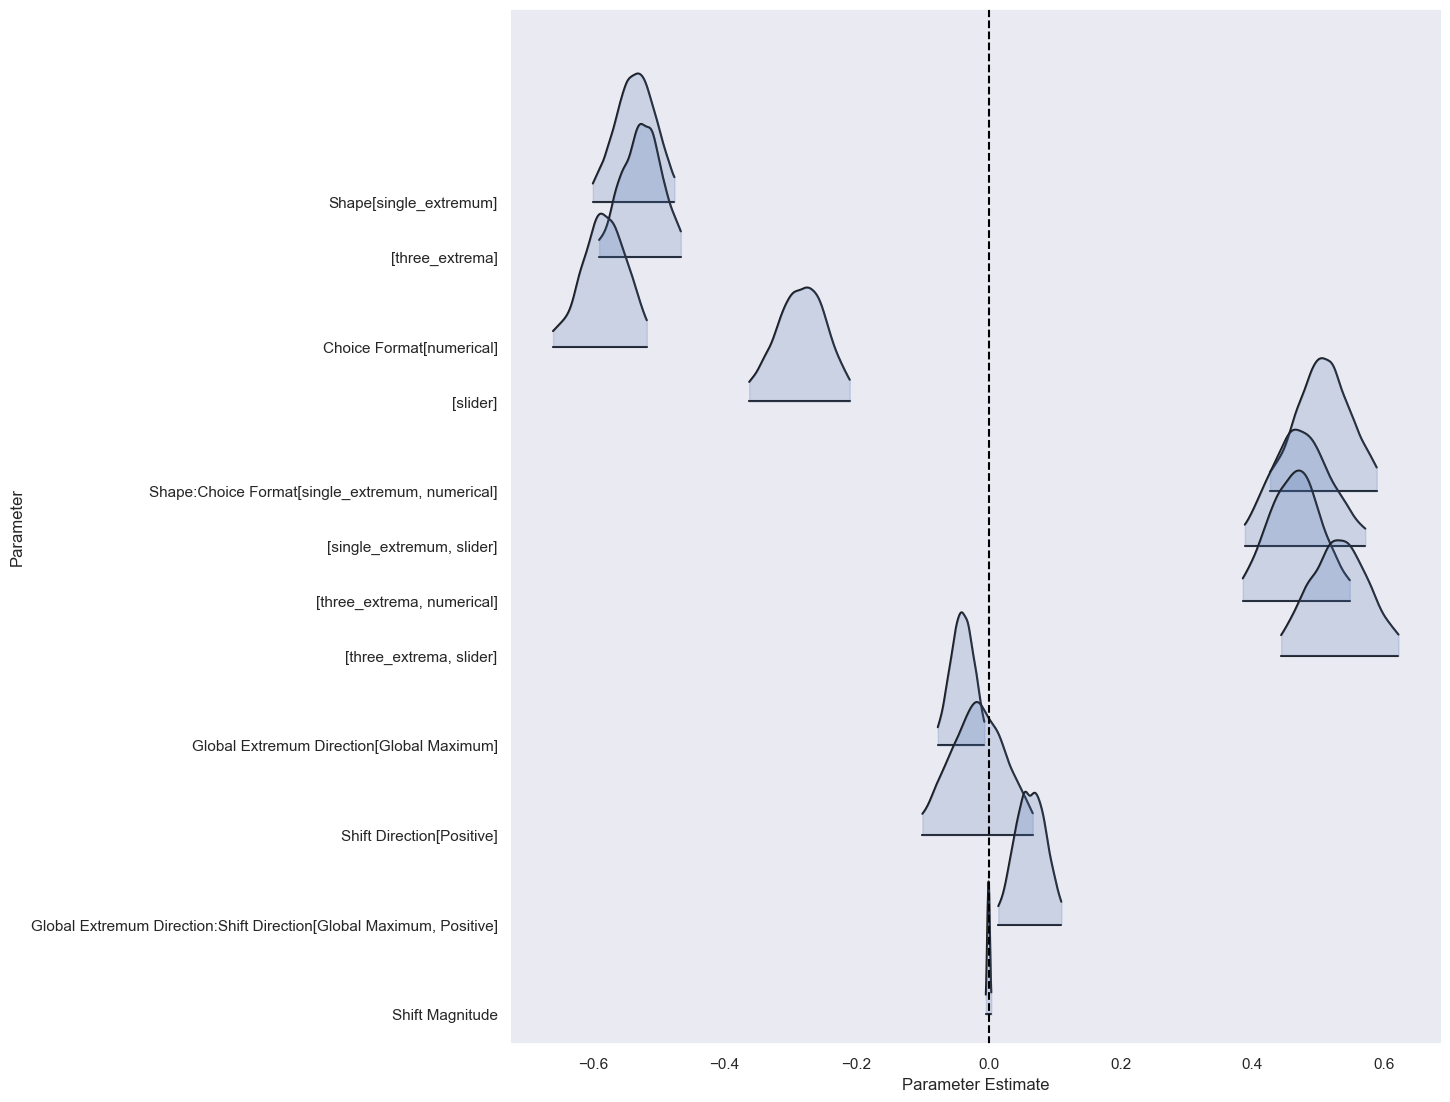

In [12]:
sns.set_context('talk')
sns.set_theme(style='darkgrid')
# fig, ax = plt.subplots()
if measure == 'accuracy':
    az.plot_forest(models['allparam_formatinteract_shapediffdirectioninteract_difference'], 
                  hdi_prob=.95, kind = 'ridgeplot', ridgeplot_alpha=0.2, combined=True,
                  var_names = ['~Intercept', '~means'], filter_vars = 'like')
else:
    az.plot_forest(models['allparam_formatinteract_shapediffdirectioninteract_difference'], 
                  hdi_prob=.95, kind = 'ridgeplot', ridgeplot_alpha=0.2, combined=True,
                  var_names = ['~rt_lam', '~Intercept', '~means'], filter_vars = 'like')

plt.axvline(0, ls = '--', color = 'black')
plt.ylabel('Parameter')
plt.xlabel('Parameter Estimate')
# fig.align_ylabels()
plt.savefig(f'figures/{measure}_ridgeplot.png', dpi = 300, transparent = False, bbox_inches = 'tight')
# plt.title(f'{measure}')
# plt.savefig('figures/rt_posteriorplot.png', dpi = 300, transparent = True)


In [28]:
model = models_with_interaction_specification(dv = 'rt', family = 'wald', 
                                            link = 'logit', 
                                              formula_rhs = 'means + shape*cond + C(direction)*C(diff_dir) + difference',
                                             )
model_samples = models['allparam_formatinteract_shapediffdirectioninteract_difference']
fitted = model.predict(model_samples, kind = 'pps')
az.plot_ppc(model_samples, mean=False)
plt.yticks((0, 1))
plt.ylabel('Accuracy Probability Density')
plt.xlabel('accuracy')
plt.xticks((0.5, 1.5), ('inaccurate', 'accurate'))
plt.savefig(f'figures/{measure}_posterior_predictive.png', dpi = 300, transparent = True, bbox_inches = 'tight')


In [17]:
comb_data

,participant,means,direction,bumps,diff_dir,trials.thisN,difference,incorrect choice,key_resp,rt,cond,accuracy,response,shape,participant_id
0,25353.0,64.0,1.0,single,1.0,0.0,8.0,left,left,3.881548,chart,False,-1,single_extremum,25353.0
1,25353.0,48.0,1.0,noisy,-1.0,1.0,-6.0,right,right,7.387671,chart,False,-1,noisy,25353.0
2,25353.0,53.0,1.0,noisy,-1.0,2.0,-10.0,left,right,6.337773,chart,True,1,noisy,25353.0
3,25353.0,64.0,-1.0,center,-1.0,3.0,-8.0,left,right,3.151569,chart,True,1,three_extrema,25353.0
4,25353.0,60.0,1.0,center,1.0,4.0,8.0,left,right,5.806216,chart,True,1,three_extrema,25353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11410,908388.0,60.0,1.0,noisy,-1.0,285.0,-8.0,left,left,2.442362,chart,False,-1,noisy,908388.0
11411,908388.0,49.0,1.0,single,-1.0,286.0,-12.0,right,left,0.798230,chart,True,1,single_extremum,908388.0
11412,908388.0,38.0,-1.0,single,-1.0,287.0,-11.0,left,right,0.681007,chart,True,1,single_extremum,908388.0
11413,908388.0,62.0,-1.0,center,-1.0,288.0,-12.0,right,left,0.802785,chart,True,1,three_extrema,908388.0


In [23]:
#Renaming columns for plotting graphs
mapper = {'cond':'Choice_Format', 
          'shape':'Shape', 
          'difference':'Shift_Magnitude', 
          'direction':'Global_Extremum_Direction', 
          'diff_dir':'Shift_Direction'
         }
comb_data.rename(columns=mapper, inplace=True)

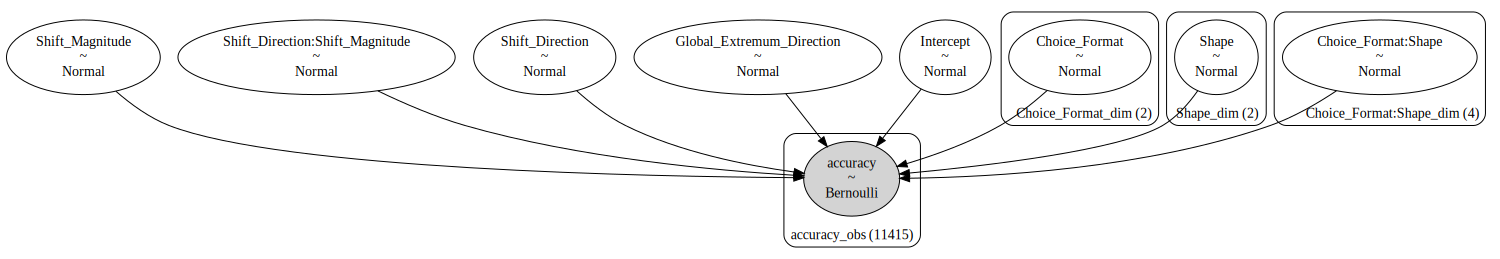

In [31]:
model = models_with_interaction_specification(dv = 'accuracy', family = 'bernoulli', 
                                            link = 'logit', data=comb_data,
                                              formula_rhs = 'Choice_Format*Shape + Global_Extremum_Direction + Shift_Direction*Shift_Magnitude'
                                             )

                                              
                                              
model.graph(name=f'figures/{measure}_model_graph.png')


In [27]:
stat_summary = az.summary(models['allparam_formatinteract_shapediffdirectioninteract_difference'], hdi_prob=0.95, stat_focus='mean', kind = 'stats',)
with pd.option_context("max_colwidth", 1000):
    stat_summary.to_latex(f'{measure}_stats_table')

C:\Users\tejas\AppData\Local\Temp\ipykernel_15132\2205521814.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  stat_summary.to_latex(f'{measure}_stats_table')


In [28]:
stat_summary

,mean,sd,hdi_2.5%,hdi_97.5%
Intercept,0.840,0.051,0.742,0.942
means,0.001,0.001,-0.001,0.002
Shape[single_extremum],-0.534,0.032,-0.600,-0.476
Shape[three_extrema],-0.525,0.032,-0.590,-0.466
Choice Format[numerical],-0.582,0.036,-0.660,-0.518
Choice Format[slider],-0.284,0.039,-0.363,-0.210
"Shape:Choice Format[single_extremum, numerical]",0.509,0.042,0.426,0.589
"Shape:Choice Format[single_extremum, slider]",0.474,0.047,0.388,0.571
"Shape:Choice Format[three_extrema, numerical]",0.465,0.042,0.385,0.548
"Shape:Choice Format[three_extrema, slider]",0.531,0.046,0.443,0.622
